In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
class Model(nn.Module):
    
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__(*args, **kwargs)
        
        self.fc1 = nn.Linear(10, 10)

In [3]:
class IPS(optim.Optimizer):
    def __init__(self, model_params, T, lower_bound, step_decay=False, initial_decay=0):
        
        defaults = dict(T=T, lower_bound=lower_bound, step_decay=step_decay)
        
        super(IPS, self).__init__(model_params, defaults)
        
        self.best_loss = float('inf')
        self.best_params = None
        self.step_count = T * initial_decay
        
        
    @torch.no_grad()
    def step(self, closure=None):
        
        self.step_count += 1
        if closure is not None:
            with torch.enable_grad():
                rtloss = closure()
                loss = rtloss.item()
                
        for group in self.param_groups:
            T = group['T']
            l_star = group['lower_bound']
            step_decay = group['step_decay']
            # boost convergence during initial stages
            current_t = min(self.step_count, T)
            
            for param in group['params']:
                if param.grad is None:
                    continue
                
                grad = param.grad.data
                grad_norm_sq = torch.sum(grad ** 2) + 1e-8
                
                inexact_step_size = (loss - l_star) / (grad_norm_sq * ((current_t if step_decay else T) ** 0.5))
                
                # important, since we're using incremental stepsize without clamping gradient explodes
                # especially true in earlier steps
                inexact_step_size = torch.clamp(inexact_step_size, min=0.0, max=1.0)
                param.data.add_(grad, alpha=-inexact_step_size)
                
        if loss < self.best_loss:
            self.best_loss = loss
            self.best_params = [p.clone().detach() for p in self.param_groups[0]['params']]
                
        return rtloss
    
    def load_best_params(self):
        if self.best_params:
            for param, best_param in zip(self.param_groups[0]['params'], self.best_params):
                param.data.copy_(best_param)
                

In [4]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        
        self.losses = []
        

    def forward(self, x):
        x = x.view(-1, 28*28).float()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [5]:
epochs = 5
batch_size = 64

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(trainset), shuffle=True)

In [7]:
def train(model, optimizer, epochs=2):
    print(optimizer)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer

    num_epochs = epochs
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            def closure():
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                return loss

            loss = optimizer.step(closure)

            if i % 100 == 0:
                print(f'Epoch {epoch+1}, Step {i}, Loss: {loss}')
            model.losses.append(loss.item())

    print("Training complete.")
    return model

In [8]:
def test(model):
    for i, (inputs, labels) in enumerate(testloader):
        output = model(inputs)
        output = output.argmax(axis=1)
        print(accuracy_score(labels, output.detach().numpy()))

In [9]:
ipsModel = SimpleNN().to(device)
ipsOptimizer = IPS(ipsModel.parameters(), T=epochs * int(len(trainset) / batch_size), lower_bound=0)
train(ipsModel, ipsOptimizer, epochs=epochs)

IPS (
Parameter Group 0
    T: 4685
    lower_bound: 0
    step_decay: False
)
Epoch 1, Step 0, Loss: 2.335564136505127
Epoch 1, Step 100, Loss: 0.8774015307426453
Epoch 1, Step 200, Loss: 0.637464165687561
Epoch 1, Step 300, Loss: 0.5307324528694153
Epoch 1, Step 400, Loss: 0.545235276222229
Epoch 1, Step 500, Loss: 0.6288704872131348
Epoch 1, Step 600, Loss: 0.3590703308582306
Epoch 1, Step 700, Loss: 0.4415912926197052
Epoch 1, Step 800, Loss: 0.5872707366943359
Epoch 1, Step 900, Loss: 0.6488351225852966
Epoch 2, Step 0, Loss: 0.42824381589889526
Epoch 2, Step 100, Loss: 0.44921910762786865
Epoch 2, Step 200, Loss: 0.38583046197891235
Epoch 2, Step 300, Loss: 0.2128387838602066
Epoch 2, Step 400, Loss: 0.7003639936447144
Epoch 2, Step 500, Loss: 0.266439288854599
Epoch 2, Step 600, Loss: 0.3020223379135132
Epoch 2, Step 700, Loss: 0.44789671897888184
Epoch 2, Step 800, Loss: 0.3767017424106598
Epoch 2, Step 900, Loss: 0.3158453404903412
Epoch 3, Step 0, Loss: 0.17978151142597198
Ep

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [10]:
adamModel = SimpleNN().to(device)
adamOptimizer = torch.optim.Adam(adamModel.parameters(), lr=1e-3)
train(adamModel, adamOptimizer, epochs=epochs)


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epoch 1, Step 0, Loss: 2.321051597595215
Epoch 1, Step 100, Loss: 0.436744749546051
Epoch 1, Step 200, Loss: 0.29960402846336365
Epoch 1, Step 300, Loss: 0.13205420970916748
Epoch 1, Step 400, Loss: 0.1954398900270462
Epoch 1, Step 500, Loss: 0.36049118638038635
Epoch 1, Step 600, Loss: 0.2657601535320282
Epoch 1, Step 700, Loss: 0.16899433732032776
Epoch 1, Step 800, Loss: 0.058325644582509995
Epoch 1, Step 900, Loss: 0.22491861879825592
Epoch 2, Step 0, Loss: 0.09615840017795563
Epoch 2, Step 100, Loss: 0.055411528795957565
Epoch 2, Step 200, Loss: 0.12136516720056534
Epoch 2, Step 300, Loss: 0.16793832182884216
Epoch 2, Step 400, Loss: 0.1061418205499649
Epoch 2, Step 500, Loss: 0.09642881900072098
Epoch 2, Step 600, Loss: 0.04604821279644966
Epoch 2, Step 700, Loss

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [18]:
ipsDecayModel = SimpleNN().to(device)
ipsDecayOptimizer = IPS(ipsDecayModel.parameters(), T=2 * len(trainset) / 64, lower_bound=0, step_decay=True, initial_decay=0)
train(ipsDecayModel, ipsDecayOptimizer, epochs=epochs)


IPS (
Parameter Group 0
    T: 1875.0
    lower_bound: 0
    step_decay: True
)
Epoch 1, Step 0, Loss: 2.3061623573303223
Epoch 1, Step 100, Loss: 0.5522843599319458
Epoch 1, Step 200, Loss: 0.37351855635643005
Epoch 1, Step 300, Loss: 0.4963723421096802
Epoch 1, Step 400, Loss: 0.33562594652175903
Epoch 1, Step 500, Loss: 0.19106663763523102
Epoch 1, Step 600, Loss: 0.21730047464370728
Epoch 1, Step 700, Loss: 0.2046099752187729
Epoch 1, Step 800, Loss: 0.2890491783618927
Epoch 1, Step 900, Loss: 0.2094632089138031
Epoch 2, Step 0, Loss: 0.1287676841020584
Epoch 2, Step 100, Loss: 0.174358531832695
Epoch 2, Step 200, Loss: 0.35581108927726746
Epoch 2, Step 300, Loss: 0.11733653396368027
Epoch 2, Step 400, Loss: 0.1929231882095337
Epoch 2, Step 500, Loss: 0.4464591443538666
Epoch 2, Step 600, Loss: 0.2623788118362427
Epoch 2, Step 700, Loss: 0.2044697403907776
Epoch 2, Step 800, Loss: 0.3809717893600464
Epoch 2, Step 900, Loss: 0.17737676203250885
Epoch 3, Step 0, Loss: 0.0824639499187

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [21]:
rmsModel = SimpleNN().to(device)
rmsOptimizer = torch.optim.RMSprop(rmsModel.parameters(), lr=1e-3, alpha=0.99, eps=1e-08)
train(rmsModel, rmsOptimizer, epochs=epochs)

RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    weight_decay: 0
)
Epoch 1, Step 0, Loss: 2.3016605377197266
Epoch 1, Step 100, Loss: 0.32464712858200073
Epoch 1, Step 200, Loss: 0.23245663940906525
Epoch 1, Step 300, Loss: 0.29905301332473755
Epoch 1, Step 400, Loss: 0.37004825472831726
Epoch 1, Step 500, Loss: 0.4054940342903137
Epoch 1, Step 600, Loss: 0.24419616162776947
Epoch 1, Step 700, Loss: 0.2623121440410614
Epoch 1, Step 800, Loss: 0.10970036685466766
Epoch 1, Step 900, Loss: 0.05765923485159874
Epoch 2, Step 0, Loss: 0.09739947319030762
Epoch 2, Step 100, Loss: 0.07485697418451309
Epoch 2, Step 200, Loss: 0.029103916138410568
Epoch 2, Step 300, Loss: 0.053781043738126755
Epoch 2, Step 400, Loss: 0.09749265760183334
Epoch 2, Step 500, Loss: 0.030050328001379967
Epoch 2, Step 600, Loss: 0.09319556504487991
Epoch 2, Step 700, Los

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [22]:
test(adamModel)
test(ipsModel)
test(ipsDecayModel)
test(rmsModel)

0.9708
0.924
0.9516
0.9747


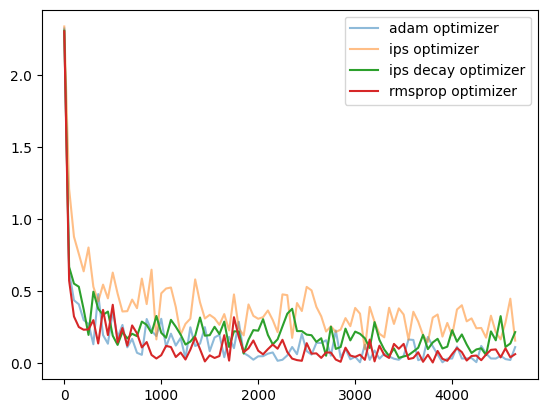

In [24]:
models = [(adamModel, 'adam optimizer'), (ipsModel, 'ips optimizer'), (ipsDecayModel, 'ips decay optimizer'), (rmsModel, 'rmsprop optimizer')]
focus = [ipsDecayModel, rmsModel]
interval = 50
for model in models:
    plt.plot(
        [i for i, loss in enumerate(model[0].losses) if i % interval == 0], 
        [loss for i, loss in enumerate(model[0].losses) if i % interval == 0], 
        label=model[1],
        alpha=0.5 if model[0] not in focus else 1
    )

plt.legend()
plt.show()

In [14]:
(len(trainset) / 64) * 2
ipsOptimizer.step_count
1876/(len(trainset) / 64)

2.0010666666666665